# Datalab: Advanced workflows to audit your data.

`Datalab` helps you identify various issues in your machine learning datasets that may negatively impact the performance of your machine learning model if not addressed. By default, `Datalab` can help you identify noisy labels, outliers, (near) duplicates, and other types of problems that commonly occur in real-world data.

`Datalab` performs these checks by utilizing the (probabilistic) predictions from *any* ML model that has already been trained or its learned representations of the data. Underneath the hood, this class calls all the appropriate cleanlab methods for your dataset and provided model outputs, in order to best audit the data and alert you of important issues. This makes it easy to apply many functionalities of this library all within a single line of code. 

This tutorial will demonstrate some advanced functionalities of `Datalab` including:

- Incremental issue search
- Specifying nondefault arguments to issue checks
- Adding a custom IssueManager
- Save and load Datalab objects

If you are new to `Datalab`, check out this [quickstart tutorial](datalab.html) for a 5-min introduction!

<div class="alert alert-info">
Quickstart
<br/>
    
Already have (out-of-sample) `pred_probs` from a model trained on an existing set of labels? Maybe you have some `features` as well? Run the code below to examine your dataset for multiple types of issues.

<div  class=markdown markdown="1" style="background:white;margin:16px">  
    
```ipython3 
from cleanlab import Datalab

lab = Datalab(data=your_dataset, label_name="column_name_of_labels")
lab.find_issues(features=your_feature_matrix, pred_probs=your_pred_probs)

lab.report()
```
   
</div>
</div>

## Install and import required dependencies

`Datalab` has additional dependencies that are not included in the standard installation of cleanlab.

You can use pip to install all packages required for this tutorial as follows:

```
!pip install matplotlib 
!pip install cleanlab[datalab]

# Make sure to install the version corresponding to this tutorial
# E.g. if viewing master branch documentation:
#     !pip install git+https://github.com/cleanlab/cleanlab.git
```

In [1]:
# Package installation (hidden on docs website).
dependencies = ["cleanlab", "matplotlib", "datasets"]  # TODO: make sure this list is updated

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install cleanlab  # for colab
    cmd = ' '.join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    missing_dependencies = []
    for dependency in dependencies:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

In [2]:
# TODO: remove cell before merging to master
# !pip install git+https://github.com/cleanlab/cleanlab.git#egg=cleanlab[datalab]

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

from cleanlab import Datalab

## Create and load the data

We'll load a toy classification dataset for this tutorial. The dataset has two numerical features and a label column with three classes.

<details><summary>See the code for data generation. **(click to expand)**</summary>
    
```ipython3
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

from sklearn.model_selection import train_test_split
from cleanlab.benchmarking.noise_generation import (
    generate_noise_matrix_from_trace,
    generate_noisy_labels,
)

SEED = 123
np.random.seed(SEED)

BINS = {
    "low": [-np.inf, 3.3],
    "mid": [3.3, 6.6],
    "high": [6.6, +np.inf],
}

BINS_MAP = {
    "low": 0,
    "mid": 1,
    "high": 2,
}


def create_data():

    X = np.random.rand(250, 2) * 5
    y = np.sum(X, axis=1)
    # Map y to bins based on the BINS dict
    y_bin = np.array([k for y_i in y for k, v in BINS.items() if v[0] <= y_i < v[1]])
    y_bin_idx = np.array([BINS_MAP[k] for k in y_bin])

    # Split into train and test
    X_train, X_test, y_train, y_test, y_train_idx, y_test_idx = train_test_split(
        X, y_bin, y_bin_idx, test_size=0.5, random_state=SEED
    )

    # Add several (5) out-of-distribution points. Sliding them along the decision boundaries
    # to make them look like they are out-of-frame
    X_out = np.array(
        [
            [-1.5, 3.0],
            [-1.75, 6.5],
            [1.5, 7.2],
            [2.5, -2.0],
            [5.5, 7.0],
        ]
    )
    # Add a near duplicate point to the last outlier, with some tiny noise added
    near_duplicate = X_out[-1:] + np.random.rand(1, 2) * 1e-6
    X_out = np.concatenate([X_out, near_duplicate])

    y_out = np.sum(X_out, axis=1)
    y_out_bin = np.array([k for y_i in y_out for k, v in BINS.items() if v[0] <= y_i < v[1]])
    y_out_bin_idx = np.array([BINS_MAP[k] for k in y_out_bin])

    # Add to train
    X_train = np.concatenate([X_train, X_out])
    y_train = np.concatenate([y_train, y_out])
    y_train_idx = np.concatenate([y_train_idx, y_out_bin_idx])

    # Add an exact duplicate example to the training set
    exact_duplicate_idx = np.random.randint(0, len(X_train))
    X_duplicate = X_train[exact_duplicate_idx, None]
    y_duplicate = y_train[exact_duplicate_idx, None]
    y_duplicate_idx = y_train_idx[exact_duplicate_idx, None]

    # Add to train
    X_train = np.concatenate([X_train, X_duplicate])
    y_train = np.concatenate([y_train, y_duplicate])
    y_train_idx = np.concatenate([y_train_idx, y_duplicate_idx])

    py = np.bincount(y_train_idx) / float(len(y_train_idx))
    m = len(BINS)

    noise_matrix = generate_noise_matrix_from_trace(
        m,
        trace=0.9 * m,
        py=py,
        valid_noise_matrix=True,
        seed=SEED,
    )

    noisy_labels_idx = generate_noisy_labels(y_train_idx, noise_matrix)
    noisy_labels = np.array([list(BINS_MAP.keys())[i] for i in noisy_labels_idx])

    return X_train, y_train_idx, noisy_labels, noisy_labels_idx, X_out, X_duplicate
```

</details>

In [4]:
from sklearn.model_selection import train_test_split
from cleanlab.benchmarking.noise_generation import (
    generate_noise_matrix_from_trace,
    generate_noisy_labels,
)

SEED = 123
np.random.seed(SEED)

BINS = {
    "low": [-np.inf, 3.3],
    "mid": [3.3, 6.6],
    "high": [6.6, +np.inf],
}

BINS_MAP = {
    "low": 0,
    "mid": 1,
    "high": 2,
}


def create_data():

    X = np.random.rand(250, 2) * 5
    y = np.sum(X, axis=1)
    # Map y to bins based on the BINS dict
    y_bin = np.array([k for y_i in y for k, v in BINS.items() if v[0] <= y_i < v[1]])
    y_bin_idx = np.array([BINS_MAP[k] for k in y_bin])

    # Split into train and test
    X_train, X_test, y_train, y_test, y_train_idx, y_test_idx = train_test_split(
        X, y_bin, y_bin_idx, test_size=0.5, random_state=SEED
    )

    # Add several (5) out-of-distribution points. Sliding them along the decision boundaries
    # to make them look like they are out-of-frame
    X_out = np.array(
        [
            [-1.5, 3.0],
            [-1.75, 6.5],
            [1.5, 7.2],
            [2.5, -2.0],
            [5.5, 7.0],
        ]
    )
    # Add a near duplicate point to the last outlier, with some tiny noise added
    near_duplicate = X_out[-1:] + np.random.rand(1, 2) * 1e-6
    X_out = np.concatenate([X_out, near_duplicate])

    y_out = np.sum(X_out, axis=1)
    y_out_bin = np.array([k for y_i in y_out for k, v in BINS.items() if v[0] <= y_i < v[1]])
    y_out_bin_idx = np.array([BINS_MAP[k] for k in y_out_bin])

    # Add to train
    X_train = np.concatenate([X_train, X_out])
    y_train = np.concatenate([y_train, y_out])
    y_train_idx = np.concatenate([y_train_idx, y_out_bin_idx])

    # Add an exact duplicate example to the training set
    exact_duplicate_idx = np.random.randint(0, len(X_train))
    X_duplicate = X_train[exact_duplicate_idx, None]
    y_duplicate = y_train[exact_duplicate_idx, None]
    y_duplicate_idx = y_train_idx[exact_duplicate_idx, None]

    # Add to train
    X_train = np.concatenate([X_train, X_duplicate])
    y_train = np.concatenate([y_train, y_duplicate])
    y_train_idx = np.concatenate([y_train_idx, y_duplicate_idx])

    py = np.bincount(y_train_idx) / float(len(y_train_idx))
    m = len(BINS)

    noise_matrix = generate_noise_matrix_from_trace(
        m,
        trace=0.9 * m,
        py=py,
        valid_noise_matrix=True,
        seed=SEED,
    )

    noisy_labels_idx = generate_noisy_labels(y_train_idx, noise_matrix)

    # TODO: Add noise to test set when we support extra splits in Datalab

    noisy_labels = np.array([list(BINS_MAP.keys())[i] for i in noisy_labels_idx])

    return X_train, y_train_idx, noisy_labels, noisy_labels_idx, X_out, X_duplicate

In [5]:
X_train, y_train_idx, noisy_labels, noisy_labels_idx, X_out, X_duplicate = create_data()

We make a scatter plot of the features, with a color corresponding to the observed labels. Incorrect given labels are highlighted in red if they do not match the true label, outliers highlighted with an a black cross, and duplicates highlighted with a cyan cross.

<details><summary>See the code to visualize the data. **(click to expand)**</summary>
    
```ipython3
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

import matplotlib.pyplot as plt

def plot_data(X_train, y_train_idx, noisy_labels_idx, X_out, X_duplicate):
    # Plot data with clean labels and noisy labels, use BINS_MAP for the legend
    fig, ax = plt.subplots(figsize=(8, 6))
    for k, v in BINS_MAP.items():
        ax.scatter(X_train[noisy_labels_idx == v, 0], X_train[noisy_labels_idx == v, 1], label=k)
    ax.set_title("Noisy labels")
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")

    # Plot true boundaries (x+y=3.3, x+y=6.6)
    ax.set_xlim(-3.5, 8.5)
    ax.set_ylim(-3.5, 8.5)
    ax.plot([-0.7, 4.0], [4.0, -0.7], color="k", linestyle="--", alpha=0.5)
    ax.plot([-0.7, 7.3], [7.3, -0.7], color="k", linestyle="--", alpha=0.5)

    # Draw red circles around the points that are misclassified (i.e. the points that are in the wrong bin)
    for i, (X, y) in enumerate(zip([X_train, X_train], [y_train_idx, noisy_labels_idx])):
        for j, (k, v) in enumerate(BINS_MAP.items()):
            ax.plot(
                X[(y == v) & (y != y_train_idx), 0],
                X[(y == v) & (y != y_train_idx), 1],
                "o",
                markerfacecolor="none",
                markeredgecolor="red",
                markersize=14,
                markeredgewidth=2.5,
                alpha=0.5,
                **{"label": "Label error" if i == 1 and j == 0 else None}
            )

    ax.scatter(X_out[:, 0], X_out[:, 1], color="k", marker="x", s=100, linewidth=2, label="Outlier")

    # Plot the exact duplicate
    ax.scatter(
        X_duplicate[:, 0],
        X_duplicate[:, 1],
        color="c",
        marker="x",
        s=100,
        linewidth=2,
        label="Duplicates",
    )
    ax.legend()
    plt.tight_layout()
```
    
</details>

In [6]:
import matplotlib.pyplot as plt

def plot_data(X_train, y_train_idx, noisy_labels_idx, X_out, X_duplicate):
    # Plot data with clean labels and noisy labels, use BINS_MAP for the legend
    fig, ax = plt.subplots(figsize=(8, 6))
    for k, v in BINS_MAP.items():
        ax.scatter(X_train[noisy_labels_idx == v, 0], X_train[noisy_labels_idx == v, 1], label=k)
    ax.set_title("Noisy labels")
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")

    # Plot true boundaries (x+y=3.3, x+y=6.6)
    ax.set_xlim(-3.5, 8.5)
    ax.set_ylim(-3.5, 8.5)
    ax.plot([-0.7, 4.0], [4.0, -0.7], color="k", linestyle="--", alpha=0.5)
    ax.plot([-0.7, 7.3], [7.3, -0.7], color="k", linestyle="--", alpha=0.5)

    # Draw red circles around the points that are misclassified (i.e. the points that are in the wrong bin)
    for i, (X, y) in enumerate(zip([X_train, X_train], [y_train_idx, noisy_labels_idx])):
        for j, (k, v) in enumerate(BINS_MAP.items()):
            ax.plot(
                X[(y == v) & (y != y_train_idx), 0],
                X[(y == v) & (y != y_train_idx), 1],
                "o",
                markerfacecolor="none",
                markeredgecolor="red",
                markersize=14,
                markeredgewidth=2.5,
                alpha=0.5,
                **{"label": "Label error" if i == 1 and j == 0 else None}
            )

    ax.scatter(X_out[:, 0], X_out[:, 1], color="k", marker="x", s=100, linewidth=2, label="Outlier")

    # Plot the exact duplicate
    ax.scatter(
        X_duplicate[:, 0],
        X_duplicate[:, 1],
        color="c",
        marker="x",
        s=100,
        linewidth=2,
        label="Duplicates",
    )
    ax.legend()
    plt.tight_layout()

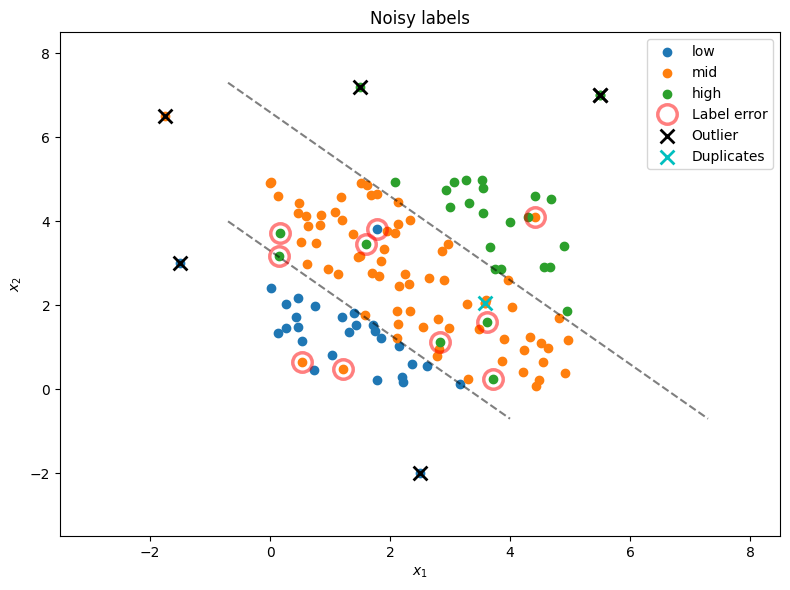

In [7]:
plot_data(X_train, y_train_idx, noisy_labels_idx, X_out, X_duplicate)

In real-world scenarios, you won't know the true labels or the distribution of the features, so we won't use these in this tutorial, except for evaluation purposes.

## Get out-of-sample predicted probabilities from a classifier

To detect certain types of issues in classification data (e.g. label errors), `Datalab` relies on predicted class probabilities from a trained model. Ideally, the prediction for each example should be out-of-sample (to avoid overfitting), coming from a copy of the model that was not trained on this example. 

This tutorial uses a simple logistic regression model 
and the `cross_val_predict()` function from scikit-learn to generate out-of-sample predicted class probabilities for every example in the training set. You can replace this with *any* other classifier model and train it with cross-validation to get out-of-sample predictions.

In [8]:
model = LogisticRegression()
pred_probs = cross_val_predict(
    estimator=model, X=X_train, y=noisy_labels, cv=5, method="predict_proba"
)

## Instantiate Datalab object

Here we instantiate the Datalab object that will be used in the remainder in the tutorial by passing in the data created above.

`Datalab` has several ways of loading the data. In this case, we'll simply wrap the training features and noisy labels in a dictionary so that we can pass it to `Datalab`.



In [9]:
data = {"X": X_train, "y": noisy_labels}

lab = Datalab(data, label_name="y")

## **Functionality 1**: Incremental issue search 

We can call `find_issues` multiple times on a `Datalab` object to detect issues one type at a time.

This is done via the `issue_types` argument which accepts a dictionary of issue types and any corresponding keyword arguments to specify nondefault keyword arguments to use for detecting each type of issues. In this first call, we only want to detect label issues, which are detected solely based on `pred_probs`, hence there is no need for us to pass in `features` here.

In [10]:
lab.find_issues(pred_probs=pred_probs, issue_types={"label": {}})  
lab.report()

Finding label issues ...
Audit complete. 11 issues found in the dataset.
Here is a summary of the different kinds of issues found in the data:

issue_type    score  num_issues
     label 0.909091          11

(Note: A lower score indicates a more severe issue across all examples in the dataset.)


----------------------- label issues -----------------------

Number of examples with this issue: 11
Overall dataset quality in terms of this issue: : 0.9091

Examples representing most severe instances of this issue:
     is_label_issue  label_score given_label predicted_label
77             True     0.006939        high             mid
7              True     0.007830         low             mid
40             True     0.014826         mid             low
107            True     0.021220        high             mid
120            True     0.026403        high             mid


We can check for additional types of issues with the same `Datalab`. Here, we would like to detect outliers and near duplicates which both utilize the features of the data.

Notice that this second call to `find_issues()` updates the output of `report()`, we can see the existing label issues detected alongside the new issues.

In [11]:
lab.find_issues(features=data["X"], issue_types={"outlier": {}, "near_duplicate": {}})
lab.report()

Finding outlier issues ...
Fitting OOD estimator based on provided features ...
Finding near_duplicate issues ...
Audit complete. 25 issues found in the dataset.
Here is a summary of the different kinds of issues found in the data:

    issue_type    score  num_issues
         label 0.909091          11
near_duplicate 0.246459           8
       outlier 0.522080           6

(Note: A lower score indicates a more severe issue across all examples in the dataset.)


----------------------- label issues -----------------------

Number of examples with this issue: 11
Overall dataset quality in terms of this issue: : 0.9091

Examples representing most severe instances of this issue:
     is_label_issue  label_score given_label predicted_label
77             True     0.006939        high             mid
7              True     0.007830         low             mid
40             True     0.014826         mid             low
107            True     0.021220        high             mid
120      

## **Functionality 2**: Specifying nondefault arguments

We can also overwrite previously-executed checks for a type of issue. Here we re-run the detection of outliers, but specify that different non-default settings should be used (in this case, the number of neighbors `k` compared against to determine which datapoints are outliers). 
The results from this new detection will replace the original outlier detection results in the updated `Datalab`. You could similarly specify non-default settings for other issue types in the first call to `Datalab.find_issues()`.

In [12]:
lab.find_issues(features=data["X"], issue_types={"outlier": {"k": 80}})
lab.report()

Finding outlier issues ...
Fitting OOD estimator based on provided features ...
Audit complete. 25 issues found in the dataset.
Here is a summary of the different kinds of issues found in the data:

    issue_type    score  num_issues
         label 0.909091          11
near_duplicate 0.246459           8
       outlier 0.149016           6

(Note: A lower score indicates a more severe issue across all examples in the dataset.)


----------------------- label issues -----------------------

Number of examples with this issue: 11
Overall dataset quality in terms of this issue: : 0.9091

Examples representing most severe instances of this issue:
     is_label_issue  label_score given_label predicted_label
77             True     0.006939        high             mid
7              True     0.007830         low             mid
40             True     0.014826         mid             low
107            True     0.021220        high             mid
120            True     0.026403        hig

/Users/huiwengoh/Documents/Cleanlab/Code/branches/datalab/cleanlab/cleanlab/datalab/data_issues.py:159: UserWarning: Overwriting columns ['outlier_score', 'is_outlier_issue'] in self.issues with columns from issue manager OutlierIssueManager.
  warnings.warn(
/Users/huiwengoh/Documents/Cleanlab/Code/branches/datalab/cleanlab/cleanlab/datalab/data_issues.py:167: UserWarning: Overwriting row in self.issue_summary with row from issue manager OutlierIssueManager.
  warnings.warn(
/Users/huiwengoh/Documents/Cleanlab/Code/branches/datalab/cleanlab/cleanlab/datalab/data_issues.py:186: UserWarning: Overwriting key outlier in self.info with key from issue manager OutlierIssueManager.
  warnings.warn(


You can also increase the verbosity of the `report` to see additional information about the data issues and control how many top-ranked examples are shown for each issue.

In [13]:
lab.report(num_examples=10, verbosity=2)

Here is a summary of the different kinds of issues found in the data:

    issue_type    score  num_issues
         label 0.909091          11
near_duplicate 0.246459           8
       outlier 0.149016           6

(Note: A lower score indicates a more severe issue across all examples in the dataset.)


----------------------- label issues -----------------------

Number of examples with this issue: 11
Overall dataset quality in terms of this issue: : 0.9091

Examples representing most severe instances of this issue:
     is_label_issue  label_score given_label predicted_label
77             True     0.006939        high             mid
7              True     0.007830         low             mid
40             True     0.014826         mid             low
107            True     0.021220        high             mid
120            True     0.026403        high             mid
54             True     0.039117         mid             low
53             True     0.044594        high     

Notice how the number of flagged outlier issues has changed after specfying different settings to use for outlier detection.

## **Functionality 3**: Adding a custom IssueManager

`Datalab` detects pre-defined types of issues for you in one line of code: `find_issues()`. What if you want to check for other custom types of issues along with these pre-defined types, all within the same line of code?

All issue types in `Datalab` are subclasses of cleanlab's `IssueManager` class.
To register a custom issue type for use with `Datalab`, simply also make it a subclass of `IssueManager`.

The necessary members to implement in the subclass are:

- A class variable called `issue_name` that acts as a unique identifier for the type of issue.
- An instance method called `find_issues` that:
  - Computes a quality score for each example in the dataset (between 0-1), in terms of how *unlikely* it is to be an issue.
  - Flags each example as an issue or not (may be based on thresholding the quality scores).
  - Combine these in a dataframe that is assigned to an `issues` attribute of the `IssueManager`.
  - Define a summary score for the overall quality of entire dataset, in terms of this type of issue. Set this score as part of the `summary` attribute of the `IssueManager`.
  
To demonstrate this, we create an arbitrary issue type that checks the divisibility of an example's index in the dataset by 13.

In [14]:
from cleanlab.datalab.issue_manager import IssueManager
from cleanlab.datalab.factory import register


def scoring_function(idx: int, div: int = 13) -> float:
    if idx == 0:
        # Zero excluded from the divisibility check, gets the highest score
        return 1
    rem = idx % div
    inv_scale = idx // div
    if rem == 0:
        return 0.5 * (1 - np.exp(-0.1*(inv_scale-1)))
    else:
        return 1 - 0.49 * (1 - np.exp(-inv_scale**0.5))*rem/div


@register  # register this issue type for use with Datalab
class SuperstitionIssueManager(IssueManager):
    """A custom issue manager that keeps track of issue indices that
    are divisible by 13.
    """
    description: str = "Examples with indices that are divisible by 13 may be unlucky."  # Optional
    issue_name: str = "superstition"

    def find_issues(self, div=13, **_) -> None:
        ids = self.datalab.issues.index.to_series()
        issues_mask = ids.apply(lambda idx: idx % div == 0 and idx != 0)
        scores = ids.apply(lambda idx: scoring_function(idx, div))
        self.issues = pd.DataFrame(
            {
                f"is_{self.issue_name}_issue": issues_mask,
                self.issue_score_key: scores,
            },
        )
        summary_score = 1 - sum(issues_mask) / len(issues_mask)
        self.summary = self.make_summary(score = summary_score)

Once registered, this `IssueManager` will perform custom issue checks when `find_issues` is called on a `Datalab` instance.

As our `Datalab` instance here already has results from the outlier and near duplicate checks, we perform the custom issue check separately.

In [15]:
lab.find_issues(issue_types={"superstition": {}})
lab.report()

Finding superstition issues ...
Audit complete. 35 issues found in the dataset.
Here is a summary of the different kinds of issues found in the data:

    issue_type    score  num_issues
         label 0.909091          11
  superstition 0.924242          10
near_duplicate 0.246459           8
       outlier 0.149016           6

(Note: A lower score indicates a more severe issue across all examples in the dataset.)


----------------------- label issues -----------------------

Number of examples with this issue: 11
Overall dataset quality in terms of this issue: : 0.9091

Examples representing most severe instances of this issue:
     is_label_issue  label_score given_label predicted_label
77             True     0.006939        high             mid
7              True     0.007830         low             mid
40             True     0.014826         mid             low
107            True     0.021220        high             mid
120            True     0.026403        high           

## **Functionality 4**: Save and load Datalab objects

A `Datalab` can be saved to a folder at a specified path. In a future Python process, this path can be used to load the `Datalab` from file back into memory. Your dataset is not saved as part of this process, so you'll need to save/load it separately to keep working with it.

In [16]:
path = "datalab-files"
lab.save(path, force=True)

Saving the dataset (0/1 shards):   0%|          | 0/132 [00:00<?, ? examples/s]

Saved Datalab to folder: datalab-files


We can load a `Datalab` object we have on file and view the previously detected issues.

In [17]:
new_lab = Datalab.load(path)
new_lab.report()

Datalab loaded from folder: datalab-files
Here is a summary of the different kinds of issues found in the data:

    issue_type    score  num_issues
         label 0.909091          11
  superstition 0.924242          10
near_duplicate 0.246459           8
       outlier 0.149016           6

(Note: A lower score indicates a more severe issue across all examples in the dataset.)


----------------------- label issues -----------------------

Number of examples with this issue: 11
Overall dataset quality in terms of this issue: : 0.9091

Examples representing most severe instances of this issue:
     is_label_issue  label_score given_label predicted_label
77             True     0.006939        high             mid
7              True     0.007830         low             mid
40             True     0.014826         mid             low
107            True     0.021220        high             mid
120            True     0.026403        high             mid


------------------- superstiti